In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import json
import tqdm

In [2]:
dataSetsInfo = []

for file in os.listdir('train_splits'):
    if file.endswith('.csv'):
        data_id = ''.join(filter(str.isdigit, file))
        entry = {'data_id': data_id, 'train': 'train_splits/' + file}
        
        test_file = f'test_splits/test_{data_id}.csv'
        if os.path.exists(test_file):
            entry['test'] = test_file  
        
        dataSetsInfo.append(entry)  

# sort the datasets by data_id
dataSetsInfo = sorted(dataSetsInfo, key=lambda x:int(x['data_id']))
with open('dataSetsInfo.json', 'w') as f:
    json.dump(dataSetsInfo, f, indent=4)  


In [3]:
with open('dataSetsInfo.json', 'r') as f:
    dataSetsInfo = json.load(f)

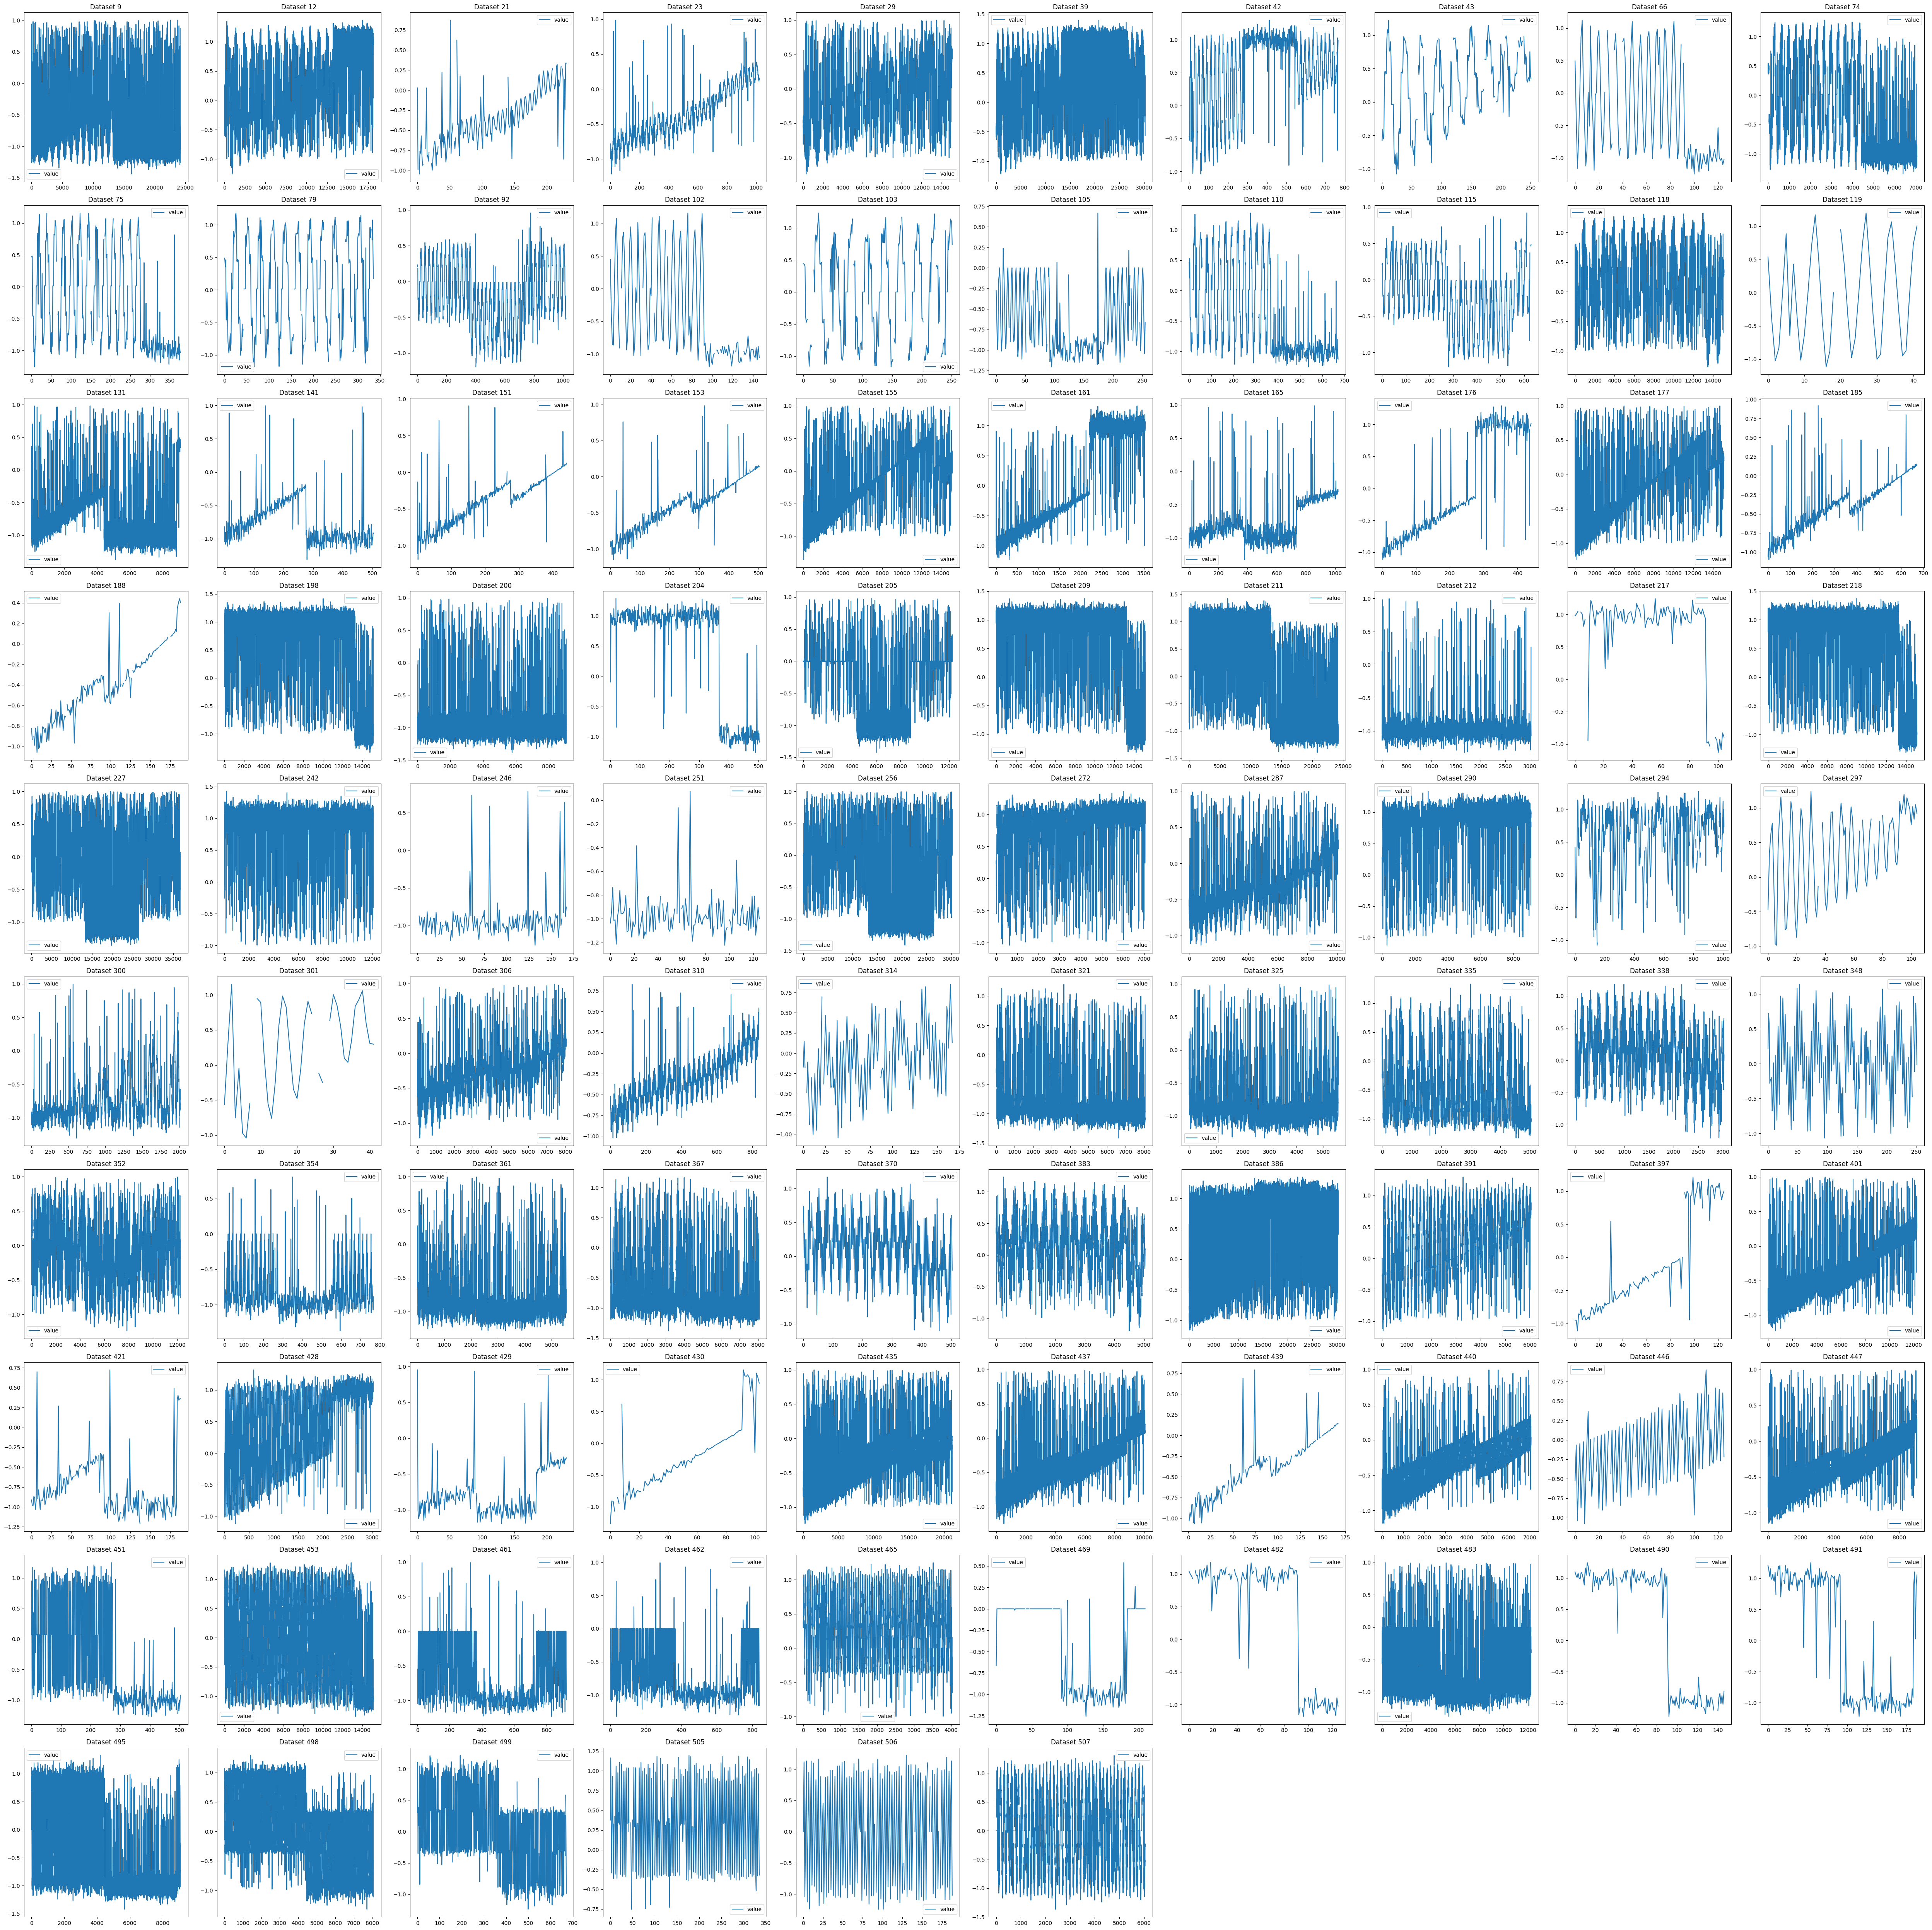

In [4]:
n_datasets = len(dataSetsInfo)
n_cols = 10  
n_rows = n_datasets // n_cols + (n_datasets % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, 5*n_rows))

axes = axes.flatten()

for i, data in enumerate(dataSetsInfo):
    df = pd.read_csv(data['train'])
    df[['value']].plot(ax=axes[i], title=f"Dataset {data['data_id']}")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [5]:
# handle null values
def handle_null_values(df):
    df.ffill(inplace=True)  # Forward fill
    # df.bfill( inplace=True)  # Backward fill
    
    return df

def time_features(df):
    df = df.set_index('timestamp')
    df.index = pd.to_datetime(df.index)
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df

# lag features
def lag_features(df, lags=7):
    for lag in range(1, lags + 1):
        df[f'lag({lag})'] = df['value'].shift(lag)
    return df

# rolling window features
def rolling_window_features(df, windows=7):
    for window in range(2, windows + 1):
        df[f'rolling_mean({window})'] = df['value'].rolling(window=window).mean()
        df[f'rolling_std({window})'] = df['value'].rolling(window=window).std()
    return df


In [66]:
def create_lag_features(df, lag):
    df[f'lag_{lag}'] = df['value'].shift(lag)
    return df

def create_rolling_features(df, window):
    df[f'rolling_mean_{window}'] = df['value'].rolling(window=window).mean()
    df[f'rolling_std_{window}'] = df['value'].rolling(window=window).std()
    return df

def evaluate_model(X, y):
    X_train, X_test = X[:-70], X[-70:]
    y_train, y_test = y[:-70], y[-70:]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

def find_optimal_lag_and_window(df, lags_range, windows_range):
    df = df.copy()
    best_lag = None
    best_window = None
    
    best_rmse = float("inf")
    for lag in lags_range:
        # Create lag features
        temp_df = create_lag_features(df, int(lag))
        temp_df = temp_df.dropna() 
        X = temp_df.drop('value', axis=1)
        y = temp_df['value']
        rmse = evaluate_model(X, y)
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = lag
    best_rmse = float("inf")
    for window in windows_range:
        # Create rolling features
        temp_df = create_rolling_features(df, int(window))
        temp_df = temp_df.dropna() 
        X = temp_df.drop('value', axis=1)
        y = temp_df['value']
        rmse = evaluate_model(X, y)
        if rmse < best_rmse:
            best_rmse = rmse
            best_window = window
    return best_lag, best_window , best_rmse
        


In [67]:
def pipeline(df, lags=7, windows=7,train=True):
    # shift the value must the target for the next time step
    df['value'] = df['value'].shift(-1)
    df.dropna(axis=1, how='all', inplace=True) # Drop columns with all NaN values
    df = handle_null_values(df)
    df = time_features(df)
    if train:
        best_lag, best_window, _ = find_optimal_lag_and_window(df, range(1, 7), range(2, 7))
    else:
        best_lag, best_window = lags, windows
    df = lag_features(df, lags=int(best_lag))
    df = rolling_window_features(df, windows=int(best_window))
    if 'anomaly' in df.columns:
        df['anomaly'] = df['anomaly'].astype(int)
    df = handle_null_values(df)
    df.dropna(inplace=True)
    return df, best_lag, best_window

In [87]:
dfs_train = []
dfs_test = []
dfs_validation = []
models = []
summary_csv = []
for data in tqdm.tqdm(dataSetsInfo):
    df_train = pd.read_csv(data['train'])
    df_test = pd.read_csv(data['test'])

    df_train, best_lag, best_window = pipeline(df_train, train=True)
    df_test,_,_ = pipeline(df_test , best_lag , best_window ,train=False)

    # scale the data
    scaler = StandardScaler()
    X_train = df_train.drop(['value'], axis=1)
    X_train = scaler.fit_transform(X_train)
    y_train = df_train['value']
    df_train = pd.DataFrame(np.concatenate([y_train.values.reshape(-1, 1), X_train], axis=1), columns=['value'] + df_train.columns[1:].tolist())
    X_test = df_test.drop(['value'], axis=1)
    X_test = scaler.transform(X_test)
    y_test = df_test['value']
    df_test = pd.DataFrame(np.concatenate([y_test.values.reshape(-1, 1), X_test], axis=1), columns=['value'] + df_test.columns[1:].tolist())


    split_point = int(len(df_train) * 0.95)  # 95% train, 5% validation
    train_data = df_train.iloc[:split_point]
    val_data = df_train.iloc[split_point:]

    dfs_train.append({'data_id': data['data_id'], 'df': train_data})
    dfs_validation.append({'data_id': data['data_id'], 'df': val_data})
    dfs_test.append({'data_id': data['data_id'], 'df': df_test})

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror', 
        max_depth=5,
        learning_rate=0.01
    )

    reg.fit(
        train_data.drop(['value'], axis=1), 
        train_data['value'], 
        eval_set=[(val_data.drop(['value'], axis=1), val_data['value'])], 
        verbose=False 
    )

    models.append({'data_id': data['data_id'], 'model': reg,'previous_data':max(best_lag,best_window),'best_lag':best_lag,'best_window':best_window}) 

100%|██████████| 96/96 [04:10<00:00,  2.61s/it]


In [88]:
def evaluate_by_id(data_id, dfs_train, dfs_test, models):
    train_entry = next((entry for entry in dfs_train if entry['data_id'] == data_id), None)
    test_entry = next((entry for entry in dfs_test if entry['data_id'] == data_id), None)

    if train_entry is not None and test_entry is not None:
        model_entry = next((model for model in models if model['data_id'] == data_id), None)
        if model_entry is None:
            print(f'Model for Data ID {data_id} not found.')
            return

        # Use the same features as training
        X_test = test_entry['df'].drop(['value'], axis=1)

        # Make predictions
        y_pred = model_entry['model'].predict(X_test)

        # # Output predictions
        # print("Predictions:", y_pred)

        # Calculate Mean Squared Error
        mse = mean_squared_error(test_entry['df']['value'], y_pred)
        # print('Mean Squared Error for Data ID', data_id, ':', mse)
        return float(mse)
    else:
        print(f'Data ID {data_id} not found in training or testing datasets.')
        return None

In [89]:
list_mean_std = []
for data in dfs_train:
    mean = data['df']['value'].mean()
    std = data['df']['value'].std()
    list_mean_std.append({'mean': mean, 'std': std, 'data_id': data['data_id']})


In [90]:
mse_values = []
for data in dataSetsInfo:
    data_id = data['data_id']
    mse = evaluate_by_id(data_id, dfs_train, dfs_test, models)
    if mse is not None:
        mse_values.append({'data_id': data_id, 'mse': mse})
    else:
        print(f'Error evaluating Data ID {data_id}')

In [91]:
# list for all the mse values > 0.3
anomalies = []
for mse in mse_values:
    if mse['mse'] > 0.3:
        anomalies.append(mse['data_id'])

In [92]:
def find_df_by_id(data_id, dfs):
    entry = next((entry for entry in dfs if entry['data_id'] == data_id), None)
    if entry is not None:
        return entry['df']
    else:
        print(f'Data ID {data_id} not found.')
        return None

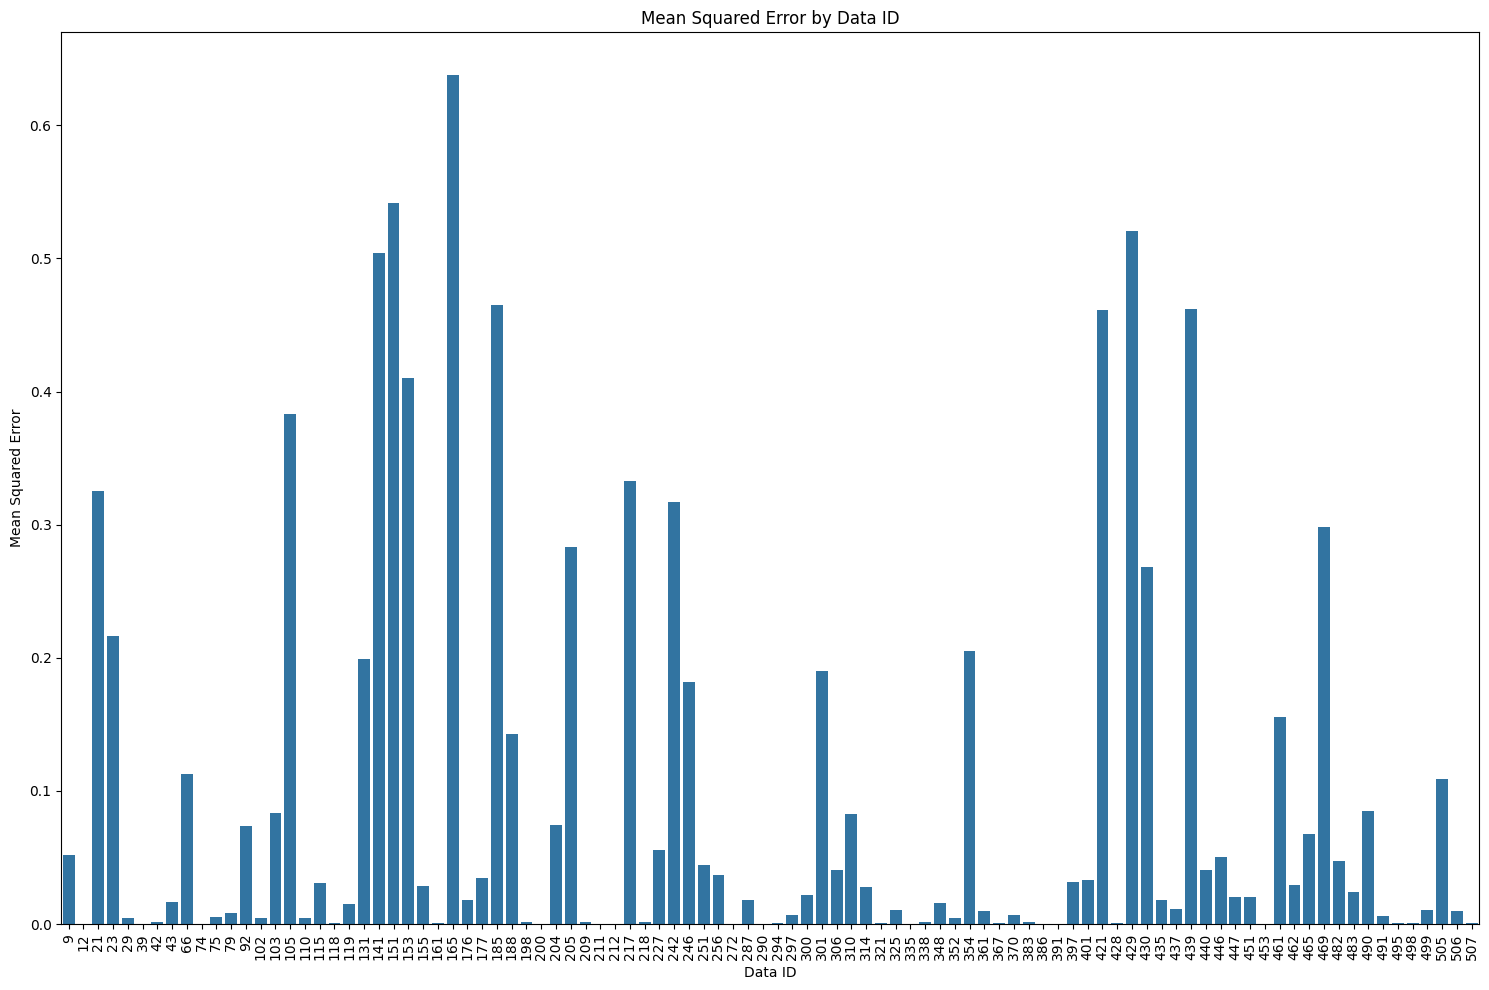

average mse:  0.09468815448466843


In [93]:
plt.figure(figsize=(15, 10))
mse_df = pd.DataFrame(mse_values)
sns.barplot(x='data_id', y='mse', data=mse_df)
plt.title('Mean Squared Error by Data ID')
plt.xlabel('Data ID')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("average mse: ", mse_df['mse'].mean())

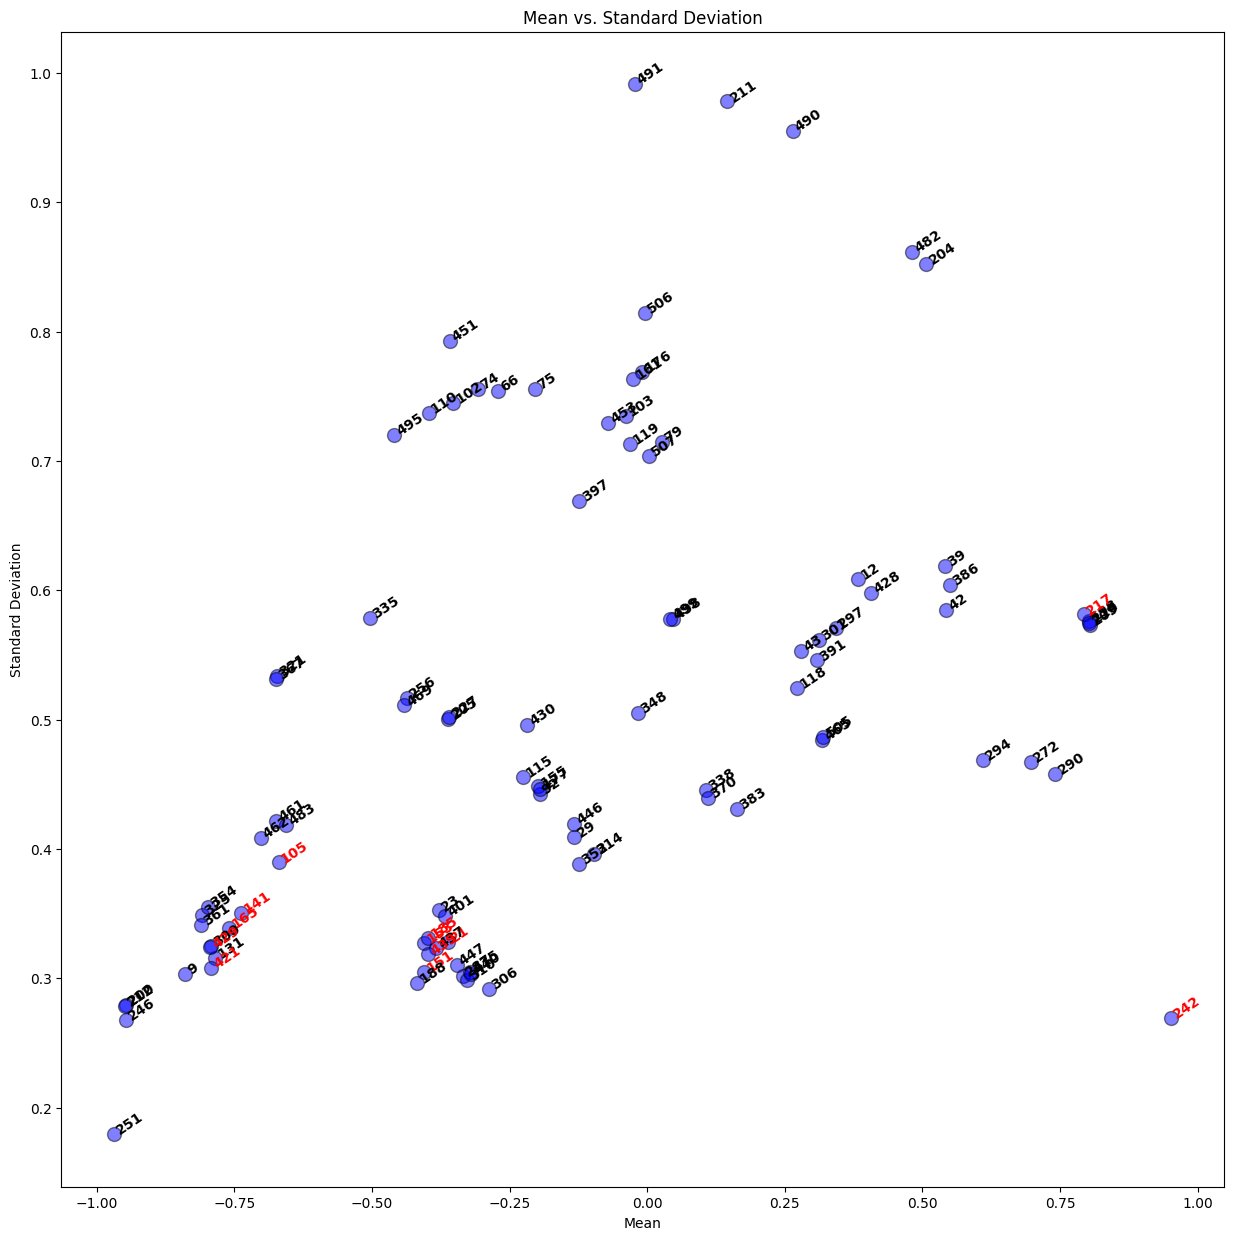

In [94]:
# plot the mean and std
df_mean_std = pd.DataFrame(list_mean_std)
df_mean_std.set_index('data_id', inplace=True)
df_mean_std.plot(kind='scatter', x='mean', y='std', title='Mean vs. Standard Deviation', figsize=(15, 15), s=100, alpha=0.5, color='blue', edgecolors="black")
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')
for data_id, row in df_mean_std.iterrows():
    if data_id in anomalies:
        plt.text(row['mean'], row['std'], data_id, fontsize=10, weight='bold', rotation=34, color='red')
    else:
        plt.text(row['mean'], row['std'], data_id, fontsize=10, weight='bold', rotation=34)

plt.show()

In [76]:
# median mse
print("median mse: ", mse_df['mse'].median())

# min mse
print("min mse: ", mse_df['mse'].min())

# max mse
print("max mse: ", mse_df['mse'].max())

# standard deviation of mse
print("std mse: ", mse_df['mse'].std())

# average mse 
print("average mse: ", mse_df['mse'].mean())

median mse:  0.02001910835726098
min mse:  0.00014845087095131978
max mse:  0.6379916934538631
std mse:  0.15263293068187786
average mse:  0.09468815448466843


In [79]:
data_id_to_evaluate = '453'  # Replace with your actual data_id
evaluate_by_id(data_id_to_evaluate, dfs_train, dfs_test, models)

0.00028427219398663775

In [80]:
df = find_df_by_id(data_id_to_evaluate, dfs_train)
df

value      hour  dayofweek   quarter     month  year  dayofyear  \
0      0.000000 -1.662152   0.000000 -0.375961 -1.226603   0.0  -1.716528   
1      0.282341 -1.662152   0.000000 -0.375961 -1.226603   0.0  -1.716528   
2      0.230947 -1.517655   0.000000 -0.375961 -1.226603   0.0  -1.716528   
3      0.316131 -1.517655   0.000000 -0.375961 -1.226603   0.0  -1.716528   
4      0.250751 -1.517655   0.000000 -0.375961 -1.226603   0.0  -1.716528   
...         ...       ...        ...       ...       ...   ...        ...   
14355 -0.922313  0.794292   0.499934  2.659847  1.744764   0.0   1.550613   
14356 -0.895514  0.794292   0.499934  2.659847  1.744764   0.0   1.550613   
14357 -0.909563  0.794292   0.499934  2.659847  1.744764   0.0   1.550613   
14358 -0.944888  0.794292   0.499934  2.659847  1.744764   0.0   1.550613   
14359 -0.914393  0.794292   0.499934  2.659847  1.744764   0.0   1.550613   

       dayofmonth  weekofyear    lag(1)    lag(2)    lag(3)  rolling_mean(2)  \
0       -1.547908   -1.709097  0.155691  0.155603  0.155521         0.159229   
1       -1.547908   -1.709097  0.155691  0.155603  0.155521         0.354791   
2       -1.547908   -1.709097  0.538246  0.155603  0.155521         0.514756   
3       -1.547908   -1.709097  0.468610  0.538179  0.155521         0.538160   
4       -1.547908   -1.709097  0.584029  0.468539  0.538115         0.551877   
...           ...         ...       ...       ...       ...              ...   
14355   -0.759681    1.511042 -1.094448 -1.058562 -1.301056        -1.118679   
14356   -0.759681    1.511042 -1.093983 -1.094607 -1.058701        -1.099880   
14357   -0.759681    1.511042 -1.057673 -1.094142 -1.094747        -1.091048   
14358   -0.759681    1.511042 -1.076708 -1.057829 -1.094282        -1.125247   
14359   -0.759681    1.511042 -1.124571 -1.076866 -1.057968        -1.128592   

       rolling_std(2)  
0           -0.564148  
1            0.490049  
2           -0.372254  
3           -0.246091  
4           -0.320034  
...               ...  
14355       -0.562868  
14356       -0.464088  
14357       -0.511693  
14358       -0.432254  
14359       -0.450289  

[14360 rows x 14 columns]

In [81]:
# save models
dir = 'models'
if not os.path.exists(dir):
    os.makedirs(dir)

for model in models:
    model['model'].save_model(f'{dir}/model_{model["data_id"]}.json')

In [113]:
# save the number of previous data, best lag and best window to a csv file
summary_csv = []
for model in models:
    summary_csv.append({'data_id': model['data_id'], 'previous_data': model['previous_data']+1, 'best_lag': model['best_lag'], 'best_window': model['best_window']})


with open('summary.json', 'w') as f:
    json.dump(summary_csv, f, indent=4)
df_summary = pd.DataFrame(summary_csv)
df_summary.drop(columns=['best_lag','best_window'], inplace=True)
df_summary.to_csv('summary.csv', index=False)

In [110]:
def load_model(data_id):
    model_path = f'models/model_{data_id}.json'
    model = xgb.XGBRegressor()
    if os.path.exists(model_path):
        model.load_model(model_path)
        return model
    else:
        return None


In [116]:
df_input = None
def make_prediction(request_body):
    dataset_id = request_body['dataset_id']
    values = request_body['values']
    
    model = load_model(dataset_id)
    if model is None:
        raise ValueError(f"Model for Data ID {dataset_id} not found.")
    
    df_input = pd.DataFrame(values)
    df_input = df_input.rename(columns={'time': 'timestamp'})  # Rename for consistency

    with open('summary.json', 'r') as f:
        summary = json.load(f)

    best_lag = None
    best_window = None
    for data in summary:
        if data['data_id'] == dataset_id:
            best_lag = data['best_lag']
            best_window = data['best_window']
            break
    
    df_input,_,_ = pipeline(df_input,best_lag,best_window,train=False)  

    df_input = df_input.drop(['value'], axis=1) 

    expected_features = model.get_booster().feature_names
    missing_features = set(expected_features) - set(df_input.columns)
    if missing_features:
        raise ValueError(f"Missing expected features: {missing_features}")
    
    prediction = model.predict(df_input)

    if len(prediction) ==0:
        response = {'prediction': 'no prediction,must have at least {} previous data'.format(max(best_lag,best_window)+1)}
    else:
        response = {'prediction': prediction.tolist()[-1]} 
    
    return response



In [122]:
# Example Request Body
request_body_example ={
    "dataset_id": "453",
    "values": [
        {"time": "2021-10-14 00:00:00", "value": -1.047212062711845},
        {"time": "2021-10-14 00:10:00", "value": -1.0462671111438924},
        {"time": "2021-10-14 00:20:00", "value": -1.1930106373878862},
        {"time": "2021-10-14 00:30:00", "value": -1.1271962688887585},
        {"time": "2021-10-14 00:40:00", "value": -0.9786381767479486},
        {"time": "2021-10-14 00:50:00", "value": None},
        {"time": "2021-10-14 01:00:00", "value": -1.1051531554368417},
        {"time": "2021-10-14 01:10:00", "value": -1.0910914391517177},
        # {"time": "2021-10-14 01:20:00", "value": -0.8959545204841793},
        # {"time": "2021-10-14 01:30:00", "value": -1.0421804239653285},
        # {"time": "2021-10-14 01:40:00", "value": -0.7462503919706338},
        # {"time": "2021-10-14 01:50:00", "value": -0.7783935109004612},
        # {"time": "2021-10-14 02:00:00", "value": -1.0192563917452533},
        # {"time": "2021-10-14 02:10:00", "value": -1.0193363555834616},
        # {"time": "2021-10-14 02:20:00", "value": -1.021676072973802},
        # {"time": "2021-10-14 02:30:00", "value": -1.0137483255363036},
        # {"time": "2021-10-14 02:40:00", "value": None}
        ]
}

if __name__ == "__main__":
    try:
        result = make_prediction(request_body_example)
        print("Prediction Result:", result)
    
    except ValueError as e:
        print(e)

Prediction Result: {'prediction': -0.8990679383277893}
